In [1]:
import torch

if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"Available GPUs: {device_count}")
    
    for i in range(device_count):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")
else:
    print("No CUDA devices found.")

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print('Using: ', device)

Available GPUs: 4
GPU 0: NVIDIA A100 80GB PCIe
GPU 1: NVIDIA A100 80GB PCIe
GPU 2: NVIDIA A100 80GB PCIe
GPU 3: NVIDIA A100 80GB PCIe
Using:  cuda:1


In [2]:
from lib.models.rirci import RIRCIModel 

def load_model_from_checkpoint(checkpoint_path):
    model = RIRCIModel(simple=True).to(device)
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
    
    return {
        'model': model,
        'optimizer': checkpoint['optimizer_state_dict'],
        'epoch': checkpoint['epoch'],
        'losses': checkpoint['losses']
    }

# Load the model
checkpoint_data = load_model_from_checkpoint(
    '/app/checkpoints/RIRCIModel-2025-05-10-090853/best_model.pth',
)

model = checkpoint_data['model']

/tmp/ipykernel_22674/2424953666.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded checkpoint from epoch 56


In [3]:
import os
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import glob

def denormalize(tensor, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    """Denormalize a tensor image with mean and std"""
    # Clone to avoid modifying original
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse normalization: (t * s) + m
    return tensor.clamp_(0, 1)  # Clamp to valid range
    

input_dir = '/data/dwh_selected_images'  
output_dir = '/data/outputs/rirci_processed_images'

os.makedirs(output_dir, exist_ok=True)

model.eval()  # Set to evaluation mode

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Adjust size as needed
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

image_paths = glob.glob(os.path.join(input_dir, '*.jpg'))    

In [4]:
for image_path in image_paths:
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        _, _, _, _, I_hat = model(image_tensor)

    
    output_image = denormalize(I_hat).squeeze(0).cpu()    
    filename = os.path.basename(image_path)
    output_path = os.path.join(output_dir, f"{filename}")
    
    save_image(output_image, output_path)


In [5]:
import random
import matplotlib.pyplot as plt
import numpy as np

def run_on_one_image(image):
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        _, _, _, _, I_hat = model(image_tensor)
    
    output_image = denormalize(I_hat).squeeze(0).cpu()
    
    def tensor_to_display(tensor):
        """Convert a tensor image to displayable numpy array"""
        if len(tensor.shape) == 3:
            tensor = tensor.permute(1, 2, 0)  # CHW to HWC
        return tensor.numpy()
    
    processed_input = tensor_to_display(denormalize(image_tensor).squeeze(0).cpu())
    result_output = tensor_to_display(output_image)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(processed_input)
    plt.title("Processed Input")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(result_output)
    plt.title("Model Output")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

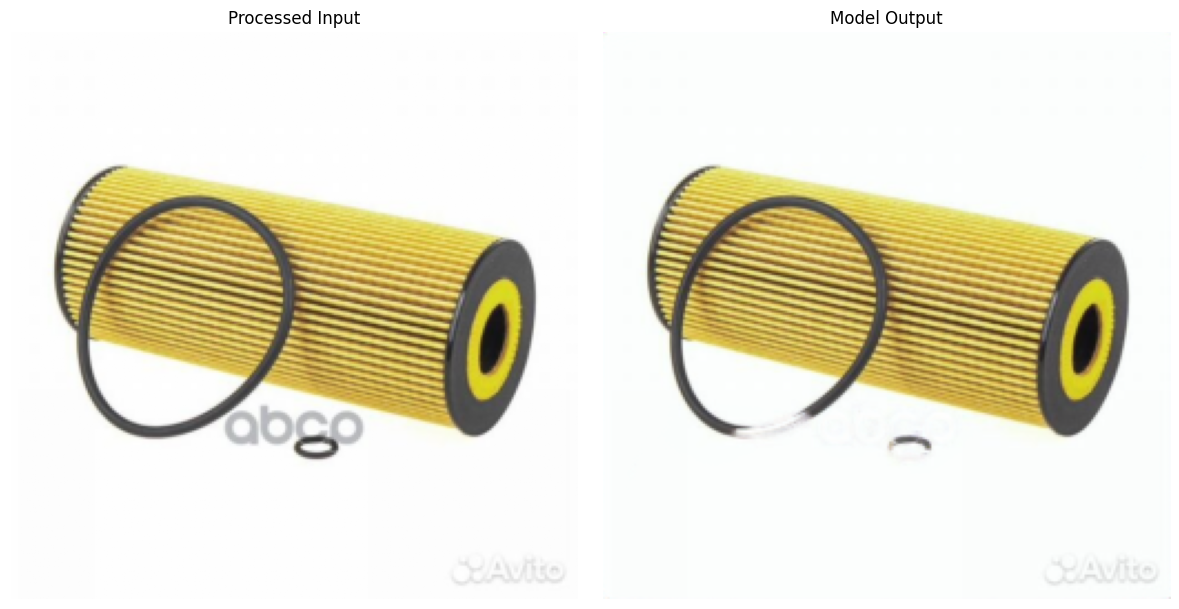

In [6]:
random_image_path = random.choice(image_paths)
image = Image.open(random_image_path).convert('RGB')

run_on_one_image(image)